In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F

from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import lightning as L

Zunächst bauen wir eine einfache Abbildung des Alphabets der Token nach IDs, die wir später embedden werden.

In [2]:
## first, we create a dictionary that maps vocabulary tokens to id numbers...
token_to_id = {'what' : 0,
               'is' : 1,
               'statquest' : 2,
               'awesome': 3,
               '<EOS>' : 4, ## <EOS> = end of sequence
              }

id_to_token = {v: k for k, v in token_to_id.items()}

print(id_to_token)

{0: 'what', 1: 'is', 2: 'statquest', 3: 'awesome', 4: '<EOS>'}


In dieser Zelle werden zwei Beispielsätze als Listen von Token-IDs erstellt und in einen Tensor umgewandelt. Anschließend werden die zugehörigen Zielsequenzen (Labels) definiert und ebenfalls als Tensor gespeichert. Schließlich werden die Eingaben und Labels in einem TensorDataset zusammengefasst und in einen DataLoader gepackt, um sie für das Training eines Modells vorzubereiten.

In [3]:
sentence1 = [token_to_id["what"], ## input #1: what is statquest <EOS> awesome
            token_to_id["is"], 
            token_to_id["statquest"], 
            token_to_id["<EOS>"],
            token_to_id["awesome"]]
sentence2 = [token_to_id["statquest"], # input #2: statquest is what <EOS> awesome
            token_to_id["is"], 
            token_to_id["what"], 
            token_to_id["<EOS>"], 
            token_to_id["awesome"]]

inputs = torch.tensor([sentence1, sentence2])

## NOTE: Because we are using a Decoder-Only Transformer the outputs, or
##       the predictions, are the input questions (minus the first word) followed by 
##       <EOS> awesome <EOS>.  The first <EOS> means we're done processing the input question
##       and the second <EOS> means we are done generating the output.
##       See the illustration above for more details.
label1 = [token_to_id["is"], 
        token_to_id["statquest"], 
        token_to_id["<EOS>"], 
        token_to_id["awesome"], 
        token_to_id["<EOS>"]]

label2 = [token_to_id["is"], 
        token_to_id["what"], 
        token_to_id["<EOS>"], 
        token_to_id["awesome"], 
        token_to_id["<EOS>"]]

labels = torch.tensor([label1,  
                       label2
                       ])

## Now let's package everything up into a DataLoader...
dataset = TensorDataset(inputs, labels) 
dataloader = DataLoader(dataset)

Sehen wir uns einen Eintrag dieses Datasets zum Beispiel an:

In [4]:
dataset[0]

(tensor([0, 1, 2, 4, 3]), tensor([1, 2, 4, 3, 4]))

Nun geht's ans Positions-Encoding:
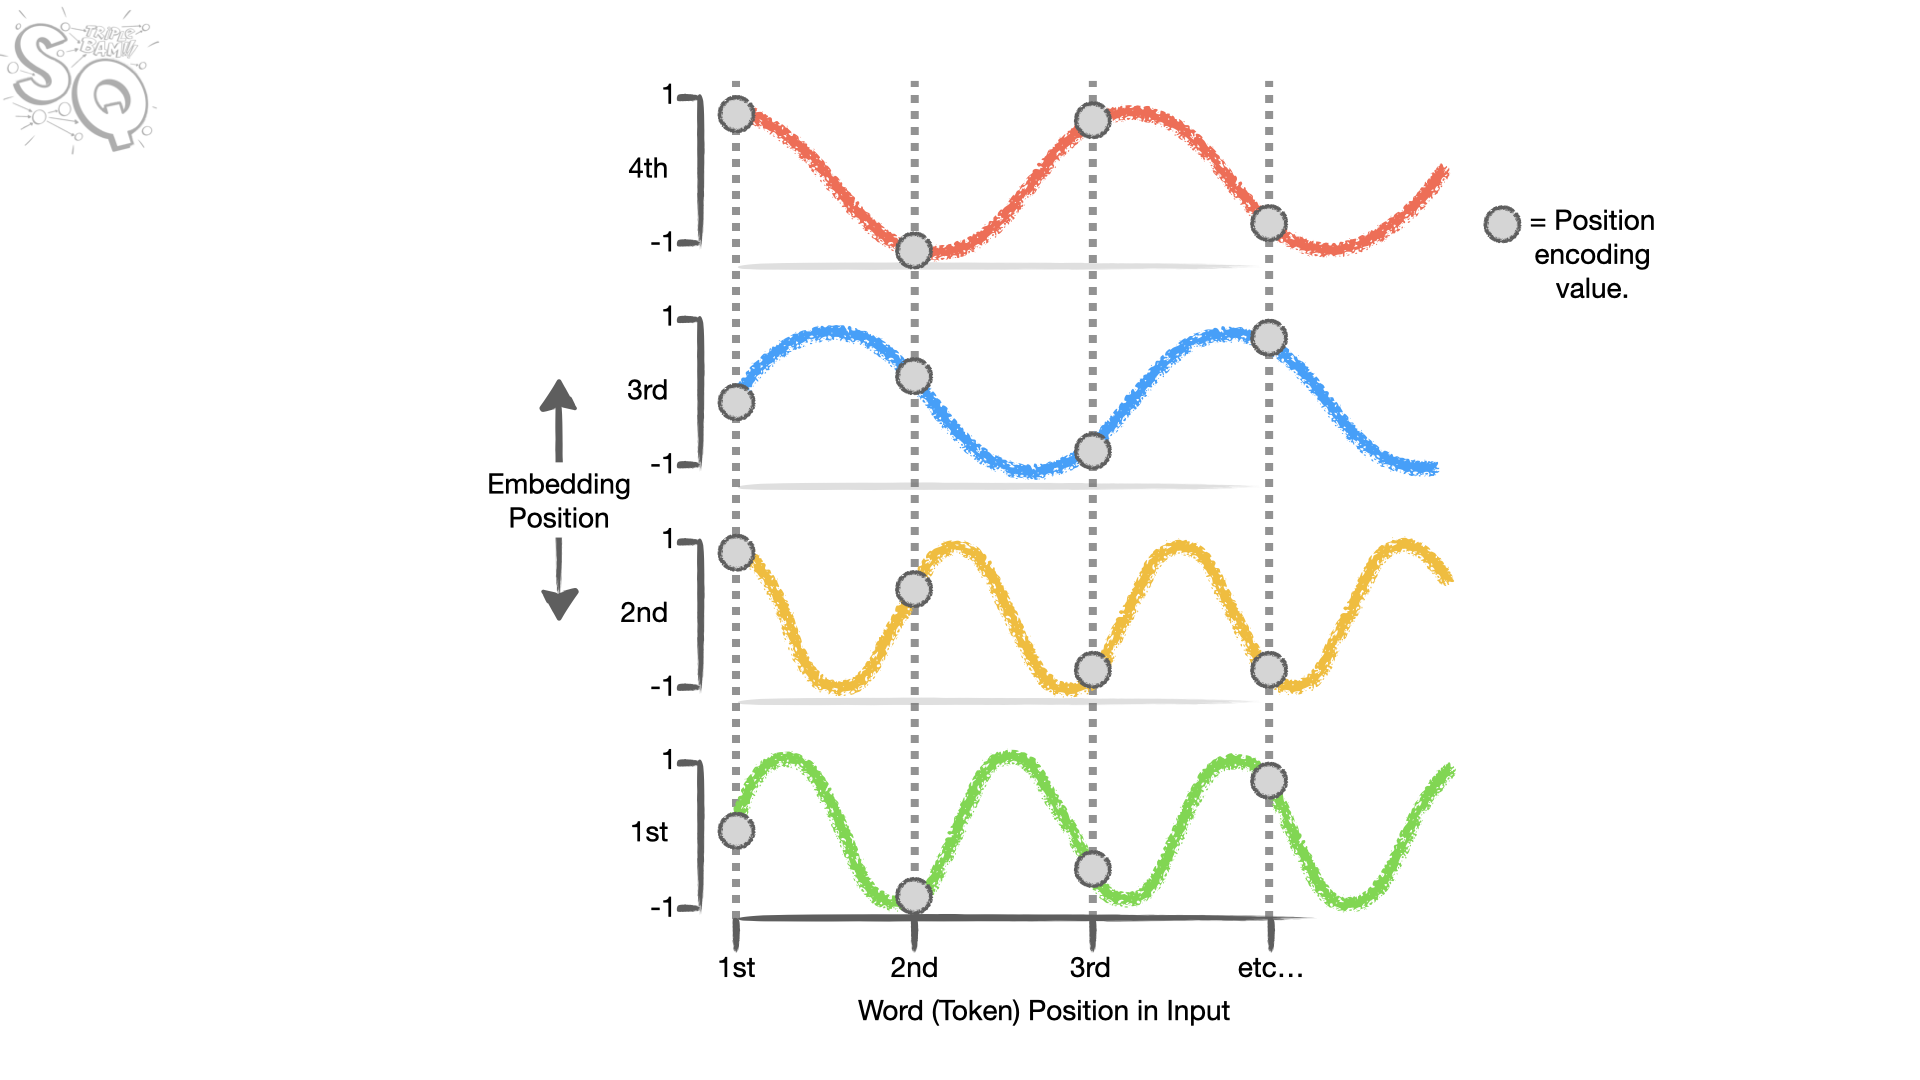

In [5]:
class PositionEncoding(nn.Module):
    
    def __init__(self, d_model=2, max_len=6):
        ## d_model = The dimension of the transformer, which is also the number of embedding values per token.
        ##           In the transformer I used in the StatQuest: Transformer Neural Networks Clearly Explained!!!
        ##           d_model=2, so that's what we'll use as a default for now.
        ##           However, in "Attention Is All You Need" d_model=512
        ## max_len = maximum number of tokens we allow as input.
        ##           Since we are precomputing the position encoding values and storing them in a lookup table
        ##           we can use d_model and max_len to determine the number of rows and columns in that
        ##           lookup table.
        ##
        ##           In this simple example, we are only using short phrases, so we are using
        ##           max_len=6 as the default setting.
        ##           However, in The Annotated Transformer, they set the default value for max_len to 5000
        
        super().__init__()
        ## We call the super's init because by creating our own __init__() method, we overwrite the one
        ## we inherited from nn.Module. So we have to explicity call nn.Module's __init__(), otherwise it
        ## won't get initialized. NOTE: If we didn't write our own __init__(), then we would not have
        ## to call super().__init__(). Alternatively, if we didn't want to access any of nn.Module's methods, 
        ## we wouldn't have to call it then either.

        ## Now we create a lookup table, pe, of position encoding values and initialize all of them to 0.
        ## To do this, we will make a matrix of 0s that has max_len rows and d_model columns.
        ## for example...
        ## torch.zeros(3, 2)
        ## ...returns a matrix of 0s with 3 rows and 2 columns...
        ## tensor([[0., 0.],
        ##         [0., 0.],
        ##         [0., 0.]])
        pe = torch.zeros(max_len, d_model)

        ## Now we create a sequence of numbers for each position that a token can have in the input (or output).
        ## For example, if the input tokens where "I'm happy today!", then "I'm" would get the first
        ## position, 0, "happy" would get the second position, 1, and "today!" would get the third position, 2.
        ## NOTE: Since we are going to be doing math with these position indices to create the 
        ## positional encoding for each one, we need them to be floats rather than ints.
        ## 
        ## NOTE: Two ways to create floats are...
        ##
        ## torch.arange(start=0, end=3, step=1, dtype=torch.float)
        ##
        ## ...and...
        ##
        ## torch.arange(start=0, end=3, step=1).float()
        ##
        ## ...but the latter is just as clear and requires less typing.
        ##
        ## Lastly, .unsqueeze(1) converts the single list of numbers that torch.arange creates into a matrix with
        ## one row for each index, and all of the indices in a single column. So if "max_len" = 3, then we
        ## would create a matrix with 3 rows and 1 column like this...
        ##
        ## torch.arange(start=0, end=3, step=1, dtype=torch.float).unsqueeze(1)
        ##
        ## ...returns...
        ##
        ## tensor([[0.],
        ##         [1.],
        ##         [2.]])        
        position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)


        ## Here is where we start doing the math to determine the y-axis coordinates on the
        ## sine and cosine curves.
        ##
        ## The positional encoding equations used in "Attention is all you need" are...
        ##
        ## PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
        ## PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
        ##
        ## ...and we see, within the sin() and cos() functions, we divide "pos" by some number that depends
        ## on the index (i) and total number of PE values we want per token (d_model). 
        ##
        ## NOTE: When the index, i, is 0 then we are calculating the y-axis coordinates on the **first pair** 
        ##       of sine and cosine curves. When i=1, then we are calculating the y-axis coordiantes on the 
        ##       **second pair** of sine and cosine curves. etc. etc.
        ##
        ## Now, pretty much everyone calculates the term we use to divide "pos" by first, and they do it with
        ## code that looks like this...
        ##
        ## div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float() * -(math.log(10000.0) / d_model))
        ##
        ## Now, at least to me, it's not obvious that div_term = 1/(10000^(2i/d_model)) for a few reasons:
        ##
        ##    1) div_term wraps everything in a call to torch.exp() 
        ##    2) It uses log()
        ##    2) The order of the terms is different 
        ##
        ## The reason for these differences is, presumably, trying to prevent underflow (getting too close to 0).
        ## So, to show that div_term = 1/(10000^(2i/d_model))...
        ##
        ## 1) Swap out math.log() for torch.log() (doing this requires converting 10000.0 to a tensor, which is my
        ##    guess for why they used math.log() instead of torch.log())...
        ##
        ## torch.exp(torch.arange(start=0, end=d_model, step=2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        ##
        ## 2) Rearrange the terms...
        ##
        ## torch.exp(-1 * (torch.log(torch.tensor(10000.0)) * torch.arange(start=0, end=d_model, step=2).float() / d_model))
        ##
        ## 3) Pull out the -1 with exp(-1 * x) = 1/exp(x)
        ##
        ## 1/torch.exp(torch.log(torch.tensor(10000.0)) * torch.arange(start=0, end=d_model, step=2).float() / d_model)
        ##
        ## 4) Use exp(a * b) = exp(a)^b to pull out the 2i/d_model term...
        ##
        ## 1/torch.exp(torch.log(torch.tensor(10000.0)))^(torch.arange(start=0, end=d_model, step=2).float() / d_model)
        ##
        ## 5) Use exp(log(x)) = x to get the original form of the denominator...
        ##
        ## 1/(torch.tensor(10000.0)^(torch.arange(start=0, end=d_model, step=2).float() / d_model))
        ##
        ## 6) Bam.
        ## 
        ## So, that being said, I don't think underflow is actually that big an issue. In fact, some coder at Hugging Face
        ## also doesn't think so, and their code for positional encoding in DistilBERT (a streamlined version of BERT, which
        ## is a transformer model)
        ## calculates the values directly - using the form of the equation found in original Attention is all you need
        ## manuscript. See...
        ## https://github.com/huggingface/transformers/blob/455c6390938a5c737fa63e78396cedae41e4e87e/src/transformers/modeling_distilbert.py#L53
        ## So I think we can simplify the code, but I'm also writing all these comments to show that it is equivalent to what
        ## you'll see in the wild...
        ##
        ## Now let's create an index for the embedding positions to simplify the code a little more...
        embedding_index = torch.arange(start=0, end=d_model, step=2).float()
        ## NOTE: Setting step=2 results in the same sequence numbers that we would get if we multiplied i by 2.
        ##       So we can save ourselves a little math by just setting step=2.

        ## And now, finally, let's create div_term...
        div_term = 1/torch.tensor(10000.0)**(embedding_index / d_model)
        
        ## Now we calculate the actual positional encoding values. Remember 'pe' was initialized as a matrix of 0s
        ## with max_len (max number of input tokens) rows and d_model (number of embedding values per token) columns.
        pe[:, 0::2] = torch.sin(position * div_term) ## every other column, starting with the 1st, has sin() values
        pe[:, 1::2] = torch.cos(position * div_term) ## every other column, starting with the 2nd, has cos() values
        ## NOTE: If the notation for indexing 'pe[]' looks cryptic to you, read on...
        ##
        ## First, let's look at the general indexing notation:
        ##
        ## For each row or column in matrix we can select elements in that
        ## row or column with the following indexs...
        ##
        ## i:j:k = select elements between i and j with stepsize = k.
        ##
        ## ...where...
        ##
        ## i defaults to 0
        ## j defaults to the number of elements in the row, column or whatever.
        ## k defaults to 1
        ##
        ## Now that we have looked at the general notation, let's look at specific
        ## examples so that we can understand it.
        ##
        ## We'll start with: pe[:, 0::2]
        ##
        ## The stuff that comes before the comma (in this case ':') refers to the rows we want to select.
        ## The ':' before the comma means "select all rows" because we are not providing specific 
        ## values for i, j and k and, instead, just using the default values.
        ##
        ## The stuff after the comma refers to the columns we want to select.
        ## In this case, we have '0::2', and that means we start with
        ## the first column (column =  0) and go to the end (using the default value for j)
        ## and we set the stepsize to 2, which means we skip every other column.
        ##
        ## Now to understand pe[:, 1::2]
        ##
        ## Again, the stuff before the comma refers to the rows, and, just like before
        ## we use default values for i,j and k, so we select all rows.
        ##
        ## The stuff that comes after the comma refers to the columns.
        ## In this case, we start with the 2nd column (column = 1), and go to the end
        ## (using the default value for 'j') and we set the stepsize to 2, which
        ## means we skip every other column.
        ##
        ## NOTE: using this ':' based notation is called "indexing" and also called "slicing"
        
        ## Now we "register 'pe'.
        self.register_buffer('pe', pe) ## "register_buffer()" ensures that
                                       ## 'pe' will be moved to wherever the model gets
                                       ## moved to. So if the model is moved to a GPU, then,
                                       ## even though we don't need to optimize 'pe', it will 
                                       ## also be moved to that GPU. This, in turn, means
                                       ## that accessing 'pe' will be relatively fast copared
                                       ## to having a GPU have to get the data from a CPU.

    ## Because this class, PositionEncoding, inherits from nn.Module, the forward() method 
    ## is called by default when we use a PositionEncoding() object.
    ## In other words, after we create a PositionEncoding() object, pe = PositionEncoding(),
    ## then pe(word_embeddings) will call forward() and so this is where 
    ## we will add the position encoding values to the word embedding values
    def forward(self, word_embeddings):
    
        return word_embeddings + self.pe[:word_embeddings.size(0), :] ## word_embeddings.size(0) = number of embeddings
                                                                      ## NOTE: That second ':' is optional and 
                                                                      ## we could re-write it like this: 
                                                                      ## self.pe[:word_embeddings.size(0)]

In [6]:
class Attention(nn.Module): 
    
    def __init__(self, d_model=2):
        ## d_model = the number of embedding values per token.
        ##           In the transformer I used in the StatQuest: Transformer Neural Networks Clearly Explained!!!
        ##           d_model=2, so that's what we'll use as a default for now.
        ##           However, in "Attention Is All You Need" d_model=512

        
        super().__init__()
        
        self.d_model=d_model
        
        ## Initialize the Weights (W) that we'll use to create the
        ## query (q), key (k) and value (v) numbers for each token
        ## NOTE: Most implementations that I looked at include the bias terms
        ##       but I didn't use them in my video (since they are not in the 
        ##       original Attention is All You Need paper).
        self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        
        ## NOTE: In this simple example, we are not training on the data in "batches"
        ##       However, by defining variables for row_dim and col_dim, we could
        ##       allow for batches by setting row_dim to 1 and col_com to 2.
        self.row_dim = 0
        self.col_dim = 1

        
    def forward(self, encodings_for_q, encodings_for_k, encodings_for_v, mask=None):
        ## Create the query, key and values using the encodings
        ## associated with each token (token encodings)
        ##
        ## NOTE: For Encoder-Decoder Attention, the encodings for q come from
        ##       the decoder and the encodings for k and v come from the output
        ##       from the encoder.
        ##       In all of the other types of attention, the encodings all
        ##       come from the same source.
        q = self.W_q(encodings_for_q)
        k = self.W_k(encodings_for_k)
        v = self.W_v(encodings_for_v)

        ## Compute attention scores
        ## the equation is (q * k^T)/sqrt(d_model)
        ## NOTE: It seems most people use "reverse indexing" for the dimensions when transposing k
        ##       k.transpose(dim0, dim1) will transpose k by swapping dim0 and dim1
        ##       In standard matrix notation, we would want to swap rows (dim=0) with columns (dim=1)
        ##       If we have 3 dimensions, because of batching, and the batch was the first dimension
        ##       And thus dims are defined batch = 0, rows = 1, columns = 2
        ##       then dim0=-2 = 3 - 2 = 1. dim1=-1 = 3 - 1 = 2.
        ##       Alternatively, we could put the batches in dim 3, and thus, dim 0 would still be rows
        ##       and dim 1 would still be columns. I'm not sure why batches are put in dim 0...
        ##
        ##       Likewise, the q.size(-1) uses negative indexing to rever to the number of columns in the query
        ##       which tells us d_model. Alternatively, we could ust q.size(2) if we have batches in the first
        ##       dimension or q.size(1) if we have batches in the 3rd dimension.
        ##
        ##       Since there are a bunch of ways to index things, I think the best thing to do is use
        ##       variables "row_dim" and "col_dim" instead of numbers...
        sims = torch.matmul(q, k.transpose(dim0=self.row_dim, dim1=self.col_dim))

        scaled_sims = sims / torch.tensor(k.size(self.col_dim)**0.5)

        if mask is not None:
            ## Here we are masking out things we don't want to pay attention to,
            ## like tokens that come after the current token.
            ## We can also use masking to block out the <PAD> token,
            ## which is used when we have a batch of inputs sequences
            ## and they are not all the exact same length. Because the batch is passed
            ## in as a matrix, each input sequence has to have the same length, so we
            ## add <PAD> to the shorter sequences so that they are all as long ast the
            ## longest sequence.
            ##
            ## We replace <PAD>, or tokens that come after the current token
            ## with a very large negative number so that the SoftMax() function
            ## will give all masked elements an output value (or "probability") of 0.
            scaled_sims = scaled_sims.masked_fill(mask=mask, value=-1e9) # I've also seen -1e20 and -9e15 used in masking
        
        ## Apply softmax to determine what percent of each token's value to
        ## use in the final attention values.
        attention_percents = F.softmax(scaled_sims, dim=self.col_dim)

        ## Scale the values by their associated percentages and add them up.
        attention_scores = torch.matmul(attention_percents, v)
        
        return attention_scores

In [7]:
class DecoderOnlyTransformer(L.LightningModule):
    
    def __init__(self, num_tokens=4, d_model=2, max_len=6, seed=42):
        
        super().__init__()
        
        ## We are set the seed so that you can get the same results as me.
        L.seed_everything(seed=seed)
        
        
        ## NOTE: In this simple example, we are just using a "single layer" decoder.
        ##       If we wanted to have multiple layers of decoder, then we would
        ##       take the output of one decoder module and use it as input to
        ##       the next module.
        
        self.we = nn.Embedding(num_embeddings=num_tokens, 
                               embedding_dim=d_model)     
        
        self.pe = PositionEncoding(d_model=d_model, 
                                   max_len=max_len)

        self.self_attention = Attention(d_model=d_model)
        ## NOTE: In this simple example, we are not doing multi-head attention
        ## If we wanted to do multi-head attention, we could
        ## initailize more Attention objects like this...
        ##
        ## self.self_attention_2 = Attention(d_model=d_model)
        ## self.self_attention_3 = Attention(d_model=d_model)
        ##
        ## If d_model=2, then using 3 self_attention objects would 
        ## result in d_model*3 = 6 self-attention values per token, 
        ## so we would need to initialize
        ## a fully connected layer to reduce the dimension of the 
        ## self attention values back down to d_model like this:
        ## 
        ## self.reduce_attention_dim = nn.Linear(in_features=(num_attention_heads*d_model), out_features=d_model)

        self.fc_layer = nn.Linear(in_features=d_model, out_features=num_tokens)
        
        self.loss = nn.CrossEntropyLoss()
        
        
    def forward(self, token_ids):
                
        word_embeddings = self.we(token_ids)        
        position_encoded = self.pe(word_embeddings)
        
        ## For the decoder-only transformer, we need to use "masked self-attention" so that 
        ## when we are training we can't cheat and look ahead at
        ## what words come after the current word.
        ## To create the mask we are creating a matrix where the lower triangle
        ## is filled with 0, and everything above the diagonal is filled with 0s.
        mask = torch.tril(torch.ones((token_ids.size(dim=0), token_ids.size(dim=0)), device=self.device))
        ## NOTE: The device=self.device is needed because we are creating a new
        ##       tensor, mask, in the forward() method, which, by default, goes
        ##       to the CPU. If all we have is a CPU, then we don't need it, but
        ##       if we want to train on a GPU, we need to make sure mask goes
        ##       there too. Using self.device allows us tyo not worry about whether
        ##       or not we are using a GPU or CPU or whatever, it will make sure
        ##       mask is where it needs to go.

        ## We then replace the 0s above the digaonal, which represent the words
        ## we want to be masked out, with "True", and replace the 1s in the lower
        ## triangle, which represent the words we want to include when we calcualte
        ## self-attention for a specific word in the output, with "False".
        mask = mask == 0
        
        self_attention_values = self.self_attention(position_encoded, 
                                                    position_encoded, 
                                                    position_encoded, 
                                                    mask=mask)
        ## NOTE: If we were doing multi-head attention, we would
        ## calculate the self-attention values with the other attention objects
        ## like this...
        ##
        ## self_attention_values_2 = self.self_attention_2(...)
        ## self_attention_values 3 = self.self_attention_3(...)
        ## 
        ## ...then we would concatenate all the self attention values...
        ##
        ## all_self_attention_values = torch.cat(self_attention_values_1, ...)
        ##
        ## ...and then run them through reduce_dim to get back to d_model values per token
        ##
        ## final_self_attention_values = self.reduce_attention_dim(all_self_attention_values)
                
        residual_connection_values = position_encoded + self_attention_values
        
        fc_layer_output = self.fc_layer(residual_connection_values)
        
        return fc_layer_output
    
    
    def configure_optimizers(self): 
        ## configure_optimizers() simply passes the parameters we want to
        ## optimize to the optimzes and sets the learning rate
        return Adam(self.parameters(), lr=0.1)
    
    
    def training_step(self, batch, batch_idx): 
        ## training_step() is called by Lightning trainer when 
        ## we want to train the model.
        input_tokens, labels = batch # collect input
        output = self.forward(input_tokens[0])
        loss = self.loss(output, labels[0])
                    
        return loss

In [8]:
## First, create a model from DecoderOnlyTransformer()
model = DecoderOnlyTransformer(num_tokens=len(token_to_id), d_model=2, max_len=6, seed=43)

## Now create the input for the transformer...
model_input = torch.tensor([token_to_id["what"], 
                            token_to_id["is"], 
                            token_to_id["statquest"], 
                            token_to_id["<EOS>"]])
input_length = model_input.size(dim=0)

## Now get get predictions from the model
predictions = model(model_input) 
print(predictions)
## NOTE: "predictions" is the output from the fully connected layer,
##      not a softmax() function. We could, if we wanted to,
##      Run "predictions" through a softmax() function, but 
##      since we're going to select the item with the largest value
##      we can just use argmax instead...
## ALSO NOTE: "predictions" is a matrix, with one row of predicted values
##      per input token. Since we only want the prediction from the
##      last row (the most recent prediction) we use reverse index for the
##      row, -1.
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
print(predicted_id)
## We'll store predicted_id in an array, predicted_ids, that
## we'll add to each time we predict a new output token.
predicted_ids = predicted_id

## Now use a loop to predict output tokens until we get an 
## <EOS> token.
max_length = 6
for i in range(input_length, max_length):
    print(id_to_token[predicted_id.item()])
    if (predicted_id == token_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    model_input = torch.cat((model_input, predicted_id))
    print("i = ",i)
    predictions = model(model_input) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
## Now printout the predicted output phrase.
print("Predicted Tokens:\n") 
print(predicted_ids)
for id in predicted_ids: 
    print("\t", id_to_token[id.item()])

Seed set to 43


tensor([[ 4.9378e-02, -8.8378e-01,  2.2996e-02, -3.6237e-01,  1.2242e-01],
        [ 1.1292e+00, -6.5712e-02,  3.6462e-01,  1.1817e-01,  3.8689e-01],
        [ 8.9207e-01,  1.6804e+00,  7.5736e-01,  1.9401e+00, -1.1170e+00],
        [-1.5639e-01, -8.6718e-01, -2.0498e-04, -2.8131e-01, -5.7461e-02]],
       grad_fn=<AddmmBackward0>)
tensor([2])
statquest
i =  4
awesome
i =  5
Predicted Tokens:

tensor([2, 3, 0])
	 statquest
	 awesome
	 what


In [9]:
trainer = L.Trainer(max_epochs=30)
trainer.fit(model, train_dataloaders=dataloader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Schiendorfer\Anaconda3\envs\llm\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | we             | Embedding        | 10     | train
1 | pe          

Epoch 29: 100%|██████████| 2/2 [00:00<00:00, 61.44it/s, v_num=1] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 2/2 [00:00<00:00, 40.37it/s, v_num=1]


In [10]:
model_input = torch.tensor([token_to_id["what"], 
                            token_to_id["is"], 
                            token_to_id["statquest"], 
                            token_to_id["<EOS>"]])
input_length = model_input.size(dim=0)

predictions = model(model_input) 
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id

for i in range(input_length, max_length):
    if (predicted_id == token_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    model_input = torch.cat((model_input, predicted_id))
    
    predictions = model(model_input) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
print("Predicted Tokens:\n") 
for id in predicted_ids: 
    print("\t", id_to_token[id.item()])

Predicted Tokens:

	 awesome
	 <EOS>


In [11]:
## Now let's ask the other question...
model_input = torch.tensor([token_to_id["statquest"], 
                            token_to_id["is"], 
                            token_to_id["what"], 
                            token_to_id["<EOS>"]])
input_length = model_input.size(dim=0)

predictions = model(model_input) 
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id

for i in range(input_length, max_length):
    if (predicted_id == token_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    model_input = torch.cat((model_input, predicted_id))
    
    predictions = model(model_input) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
print("Predicted Tokens:\n") 
for id in predicted_ids: 
    print("\t", id_to_token[id.item()])

Predicted Tokens:

	 awesome
	 <EOS>
